# <center> Classical Monte Carlo methods - applied on Ising model</center>

## Introduction

In this tutorial, we will study the physics of the Ising model far away and close to the critical temperature, using Monte Carlo algorithms. These algorithms are very general and can be easily extended to other spin systems, such as the XY or the Heisenberg models.

### Overview

- Aim 1: Study the Ising model within the **local Metropolis MC algorithm** - obtaining a groundstate and calculating $\langle E(T) \rangle, \langle M(T) \rangle, c_v(T), \chi(T)$
- Aim 2: introducing two upgraded MC approaches **heat bath MC algorithm** and **Wolf cluster MC algorithm** and comparing

#### Ising model

Ising model is the model of spins that could take only values $S=\pm 1$ positioned on a lattice with the interaction $J$ between neirest neighbors ${\langle i j \rangle}$. The Hamiltonian of the Ising model is:
$$\mathcal{H} = - J \sum_{\langle i j \rangle} S_i S_j  $$
The sum is over all pairs of neighbors. In a sum over pairs of neighbors, we consider each pair only once, that is, we pick either $i$, $j$ or $j, i$. 

#### Square lattice in $d=2$
For concretness let's focus on the  $d=2$ Ising model defined square lattice and we set $J=1$ .

Consider the function square_neighbors which determines two dictionaries (site_dic and x_y_dic) and a tuple of tuples called nbr (for neighbors).
The dictionary site_dic and x_y_dic perform the calculations between rows and columns and nbr allows us to determine which sites of the lattice are the neighbors (right, up, left, down) of the current site.

In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Image

In [2]:
#defining the neighbors for 2D square lattice with N sites with PBC
def square_neighbors(L):
    N = L * L
    site_dic = {}
    x_y_dic = {}
    for j in range(N):
        row = j // L
        column = j - row * L
        site_dic[(row, column)] = j
        x_y_dic[j] = (row, column)
        nbr = []
    for j in range(N):
        row, column = x_y_dic[j]
        right_nbr = site_dic[row, (column + 1) % L]
        up_nbr = site_dic[(row + 1) % L, column]
        left_nbr = site_dic[row, (column - 1 + L) % L]
        down_nbr = site_dic[(row - 1 + L) % L, column]
        nbr.append((right_nbr, up_nbr, left_nbr, down_nbr))
    nbr = tuple(nbr)
    return nbr, site_dic, x_y_dic

In [3]:
# Iterate through the dictionary to print the data.
L=4
for row in range(L):
    for column in range(L):
        print(square_neighbors(L)[1][(row, column)], end='   ')
    print()

0   1   2   3   
4   5   6   7   
8   9   10   11   
12   13   14   15   


In [4]:
#enumerations of sites $0,...,N-1$ represented via (x, y), x,y \in $0,...,L-1$
for j in range(L**2):
    print(j, ":", square_neighbors(L)[0][j])

0 : (1, 4, 3, 12)
1 : (2, 5, 0, 13)
2 : (3, 6, 1, 14)
3 : (0, 7, 2, 15)
4 : (5, 8, 7, 0)
5 : (6, 9, 4, 1)
6 : (7, 10, 5, 2)
7 : (4, 11, 6, 3)
8 : (9, 12, 11, 4)
9 : (10, 13, 8, 5)
10 : (11, 14, 9, 6)
11 : (8, 15, 10, 7)
12 : (13, 0, 15, 8)
13 : (14, 1, 12, 9)
14 : (15, 2, 13, 10)
15 : (12, 3, 14, 11)


Let's plot some random spin configuration.

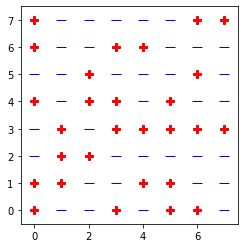

In [5]:
L = 8
N = L*L
S = [random.choice([-1, 1]) for k in range(N)]
nbr, site_dic, x_y_dic = square_neighbors(L)
x_plus = []
y_plus = []
x_minus = []
y_minus = []
for i in range(N):
    x, y = x_y_dic[i]
    if S[i] == 1:
        x_plus.append(x)
        y_plus.append(y)
    else:
        x_minus.append(x)
        y_minus.append(y)
        
#plotting 
plt.plot(x_plus, y_plus, 'rP', markersize=8)
plt.plot(x_minus, y_minus, 'b_', markersize=10)
plt.axis('scaled')
plt.axis([-0.5, L-0.5, -0.5, L-0.5])
plt.show()

#### Phase transition in Ising model

Ising model undergoes an order-disorder phase transition. In our case for $J=1>0$, we expect ferromagnetic transition below $T_c$.

From Onsager's exact solution we know that the ferromagnetic transition occurs at
$$\beta_c= \frac{\ln(1+\sqrt{2})}{2}=0.44407\ldots$$

where $\beta_c=1/k_BT_c$.

If the system is at equilibrium with a thermal bath at inverse temperature $\beta=1/k_BT$ (canonical ensemble), the partition function of the spins is:
$$ Z= \sum_{s_1=\pm 1} \sum_{s_2 =\pm 1} \ldots \sum_{s_{N-1} =\pm 1} e^{-\beta E\;(s_1, s_2, \ldots, s_{N-1})} = \sum_{\{s\}} e^{-\beta E(\{s\})}$$
Here $\sum_{\{s\}}$ indicates the sum over all configurations.

Probability $\pi(a)$ that the system is found in the configuration $\{s\}=\{a\}$ is:

$$\pi(\{a\}) =\frac{e^{-\beta E(\{a\})}}{Z} $$

In general, we could calculate all observables by exact enumeration. However, the complexity of exact enumeration grows exponentially with the system size. For an Ising model with $N$ spins, the number of available states is $2^{N}$. MC algorithm can solve such system only polynomially with system size.

## Aim 1: Study the Ising model within the local Metropolis algorithm

Let's find the ground state of the system at a given temperature.

**1) Use the local Metropolis algorithm to find a groundstate configuration after $1000$ steps at $\beta=2$ and another at $\beta=1/3$ for the size $L=50$**

Strategy:
$$\mathcal{H} = - \sum_{\langle i j \rangle} S_i S_j  $$
* When we look at a random spin, it will stay in the state $S$ or flip to $-S$ according to the mean field of the neighboring particles. The mean field acting on the spin $k$:
$$ h= \sum_j S_j \quad \text{with} \; j\; \text{nearest neighbor of} \; k  $$
If we denote the initial configuration with $a$ and the one with flipped spin with $b$, the energy difference between two configurations is:
$$\Delta = E(\{b\})-E(\{a\}) = hS + hS = 2hS, \qquad{S=\pm1}$$
* Metropolis algorithm accepts flip according to:
$$p_{\{a\} \to \{b\}} = \min \left[1, \frac{\pi(\{b\})}{\pi(\{a\})} \right] = \min \left[1, \frac{e^{-\beta E(\{b\})}}{e^{-\beta E(\{a\})}} \right] = \min \left[1, e^{-\beta \Delta} \right]= \min \left[1, e^{-2\beta hS} \right] \equiv \min \left[1, \Upsilon \right]$$

How to ask a computer to execute a task with some probability?
Accepting a flip with the probability of $\min \left[1, \Upsilon \right]$ with the help of a random number $\mbox{ran}(0,1)$. In the long runs, the times spent in $\{a\}$ and $\{b\}$ are proportional to $\pi(\{a\})$ and $\pi(\{b\})$, respectively.

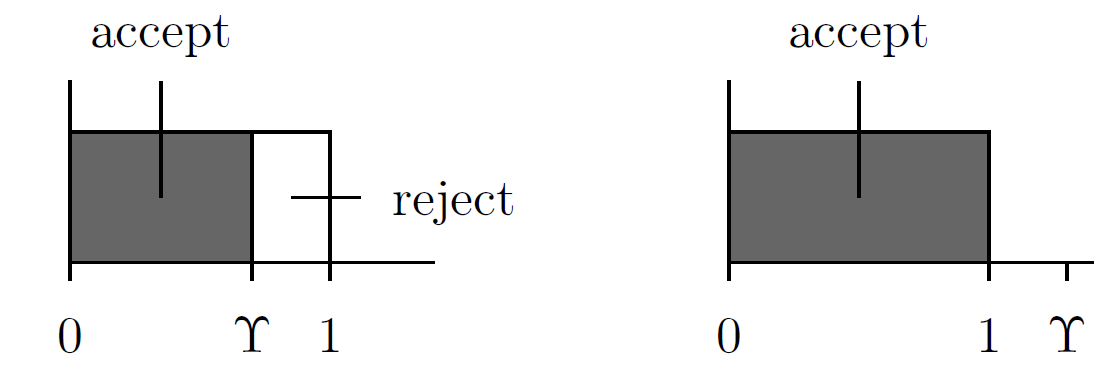

In [6]:
display(Image(filename='acceptance_probability.png', width = 600))

The function below encodes the local Metropolis algorithm, where the state of a random spin is updated accordingly to the metropolis prescription:

In [7]:
#Monte Carlo simulation for the ground state of Ising model on square lattice
def local_MC(L, N_iter, beta): #a function of lattice size, number of iteration and inverse temperature
    N = L * L
    S = [random.choice([-1, 1]) for k in range(N)] #random orientation of each spin
    nbr, site_dic, x_y_dic = square_neighbors(L) #neighbors defined above
    for i_sweep in range(N_iter): #for each iteration
        for iter in range(N): #going over sites
            k = random.randint(0, N-1) #chosing one among spins randomly
            h = sum(S[nbr[k][j]] for j in range(4)) #calculating the field of neighboring spins acting on it
            Delta_E = 2 * h * S[k] #energy difference
            BoltzmanF = np.exp(- beta * Delta_E) #calculating Boltzman factor
            if BoltzmanF > random.random(): S[k] = -S[k] #Metropolis criterion for flipping spin at position k
    return S #returning spin configuration after each iteration

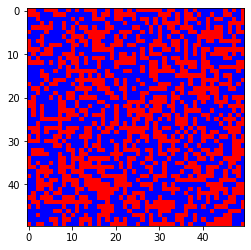

In [8]:
#example of an initial condition
L = 50
N = L*L
nbr, site_dic, x_y_dic = square_neighbors(L)
S = [random.choice([-1, 1]) for k in range(N)]
plt.imshow(np.reshape(S, (L,L)).T, cmap='bwr') #red - spin up, blue - spin down
plt.show()

Plotting the ground state

In [9]:
#function for plotting cofiguration
def plotconf(MCsimulation, L):
    plot_output = np.reshape(MCsimulation, (L,L)).T
    plt.imshow(plot_output, cmap='bwr') #red - spin up, blue - spin down

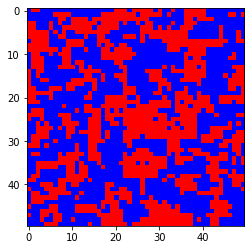

In [10]:
#above T_c
beta = 1/3 #above T_c
N_iter = 1000 #number of iterations
running = local_MC(L, N_iter, beta) 
plotconf(running, L)

Notice the difference between this and the initial configuration. The neighboring spins can still be correlated in the paramagnetic phase! During the simulations, larger and larger domains with aligned spins are formed in the course of time, until these domains reach a characteristic size which does not change in the course of the simulation.

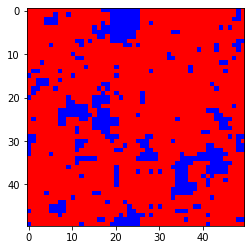

In [11]:
beta_c = 0.44407 #theoretical T_c
N_iter = 1000 #number of iterations
running = local_MC(L, N_iter, beta_c) 
plotconf(running, L)

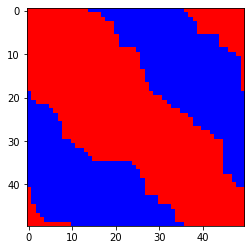

In [12]:
#below T_c
beta = 2 #below T_c
N_iter = 1000 #number of iterations
running = local_MC(L, N_iter, beta) 
plotconf(running, L)

*in polarized case sometimes 2 domains get to appear

Notice the difference between this and the initial configuration. The neighboring spins can still be correlated in the paramagnetic phase! During the simulations, larger and larger domains with aligned spins are formed in the course of time, until these domains reach a characteristic size which does not change in the course of the simulation.

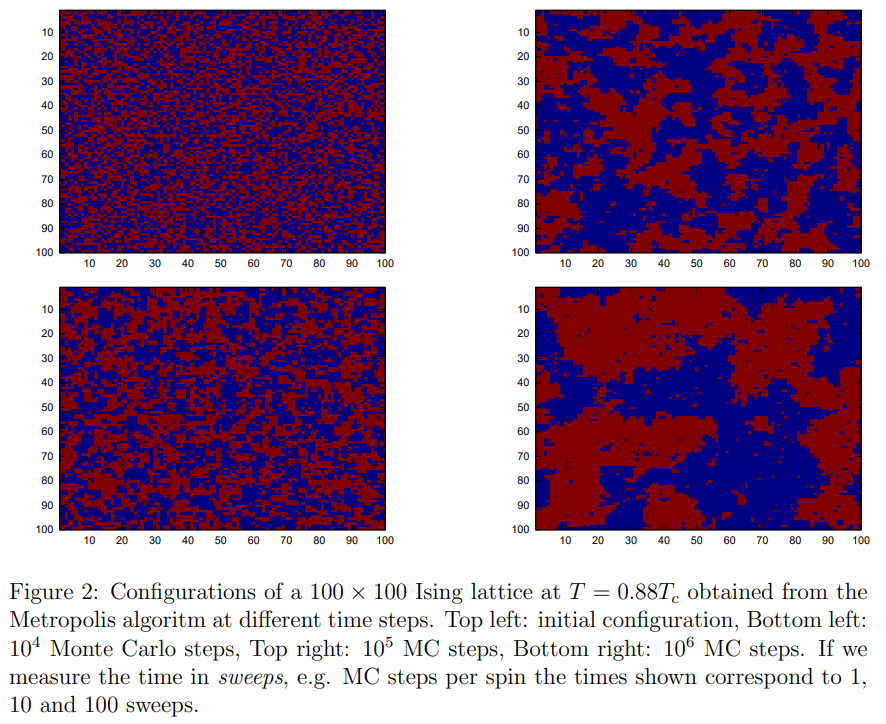

In [13]:
display(Image(filename='equilibration_Isingmodel.png', width = 600))
#reference http://itf.fys.kuleuven.be/~enrico/Teaching/monte_carlo_2012.pdf

To determine τeq the equilibration time in a simulation, we should compute some physical quantities (like the total magnetization in an Ising lattice) and plot them as a function of time. When these start to fluctuate around a constant value thermal equilibrium is reached.

**2) Calculate the energy and the magnetization for a given configuration**

In [14]:
#definition of energy and magnetization for a given configuration S

def magnetization(S,N):
    Mag=0.
    for i in range(N):
        Mag+=S[i]
    return Mag

def energy(S,N,nbr):
    en=0
    for k in range(N):
        en-= 0.5*S[k]*sum(S[nbr[k][j]] for j in range(4))
    return en

energy= -2048.0
magnetization -270.0


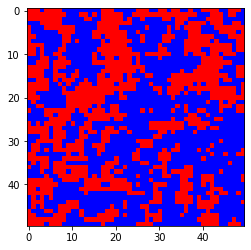

In [15]:
#above T_c - paramagnetic case
beta = 1/3 #above T_c
N_iter = 1000 #number of iterations
running = local_MC(L, N_iter, beta) 
plotconf(running, L)

#calculating energy and magnetization
print("energy=", energy(running,N,nbr))
print("magnetization", magnetization(running,N))

energy= -4788.0
magnetization 552.0


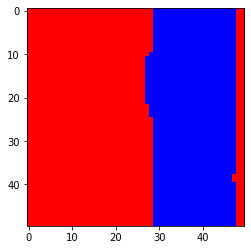

In [16]:
#below T_c - polarized case
beta = 2 #below T_c
N_iter = 1000 #number of iterations
running = local_MC(L, N_iter, beta) 
plotconf(running, L)

#calculating energy and magnetization
print("energy=", energy(running,N,nbr))
print("magnetization", magnetization(running,N))

Polarized case is easy to confirm:

$$M_{polarized}=\sum_{j=1}^{50*50}(\pm1) = \pm 2500$$
$$E_{polarized}=\sum_{i=1}^{2500}(-\frac{1}{2}\sum_{j=0}^{4}1) = -5000$$

**3) Calculate $\langle E(T)\rangle$ and $\langle M(T)\rangle$ at given temperature $T$ averaged over configurations.**

So far we have calculated $E$ and $M$ for an arbitrary configuration.

Observables can be calculated as
$$
\langle O \rangle=\frac{1}{Z}\sum_{\{s\}}O({\{s\}})e^{-\beta E(\{s\})}
$$

- Internal Energy
$$\langle E \rangle =\frac{1}{Z}\sum_{\{s\}} E(\{s\}) e^{-\beta E (\{s\})}$$
- Magnetization
$$\langle M \rangle =\frac{1}{Z}\sum_{\{s\}} M(\{s\}) e^{-\beta E(\{s\})}=\frac{1}{Z} \sum_{\{s\}} \left(\sum_{i=0}^{N-1} S_i\right) e^{-\beta E(\{s\})} = 0$$
The symmetry $E(\{s\}) = E(-\{s\})$ imposes $\langle M \rangle=0$ at all temperatures for our Hamiltonian, so theoretically $\langle M \rangle =0$.

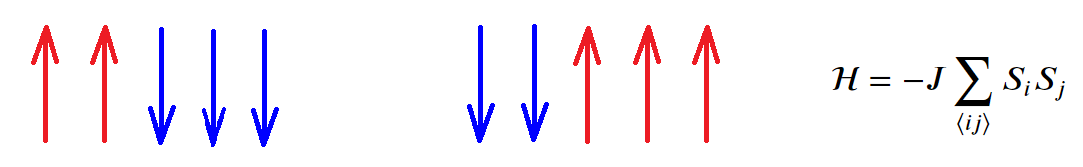

In [17]:
display(Image(filename='energy_symmetry.png', width = 400))

For our porpouses it is more convenient to define
$$\langle |M| \rangle =\frac{1}{Z} \sum_{\{s\}}   \left| \left(\sum_{i=0}^{N-1} S_i\right) \right| e^{-\beta E(\{s\})}$$

Let's edit our local Metropolis algorithm so that it returns the averaged $\langle E\rangle$ and $\langle |M|\rangle$.

In [18]:
def local_MC(L, N_iter, beta): #a function of lattice size, number of iteration and inverse temperature
    N = L * L
    S = [random.choice([-1, 1]) for k in range(N)] #random orientation of each spin
    nbr, site_dic, x_y_dic = square_neighbors(L) #neighbors defined above
    
    #added new variables
    en = 0
    m_abs = 0
    
    for i_sweep in range(N_iter): #for each iteration
        for iter in range(N): #going over sites
            k = random.randint(0, N-1) #chosing one among spins randomly
            h = sum(S[nbr[k][j]] for j in range(4)) #calculating the field of neighboring spins acting on it
            Delta_E = 2 * h * S[k] #energy difference
            BoltzmanF = np.exp(- beta * Delta_E) #calculating Boltzman factor
            if random.random() < BoltzmanF: S[k] = -S[k] #Metropolis criterion for flipping spin at position k
                
        #added
        M = magnetization(S,N)
        E = energy(S,N,nbr)
        en += E/N_iter #averaged
        m_abs += abs(M)/N_iter
    return S, en, m_abs

Let's plot the dependence of susceptibility, absolute value of magnetization, specific heat and energy as a function of the temperature.

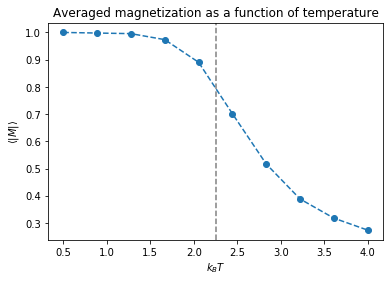

In [19]:
L = 6 #system size
N = L*L
N_iter = 10000 #number of iteration 
list_kBT = np.linspace(0.5, 4, 10) #temperature range
list_en = []
list_m_abs = []
for kBT in list_kBT: #for each temperature
    S, en, m_abs = local_MC(L, N_iter, 1/kBT)
    list_en.append(en/N)
    list_m_abs.append(m_abs/N)
    
#plotting magnetization
plt.plot(list_kBT, list_m_abs, "--o", label="k_BT")
plt.xlabel(r'$k_BT$')
plt.ylabel(r'$ \langle |M| \rangle $')
plt.axvline(x=1/beta_c, color='gray', linestyle='dashed') #theoretically expected T_c
plt.title('Averaged magnetization as a function of temperature')
plt.show()

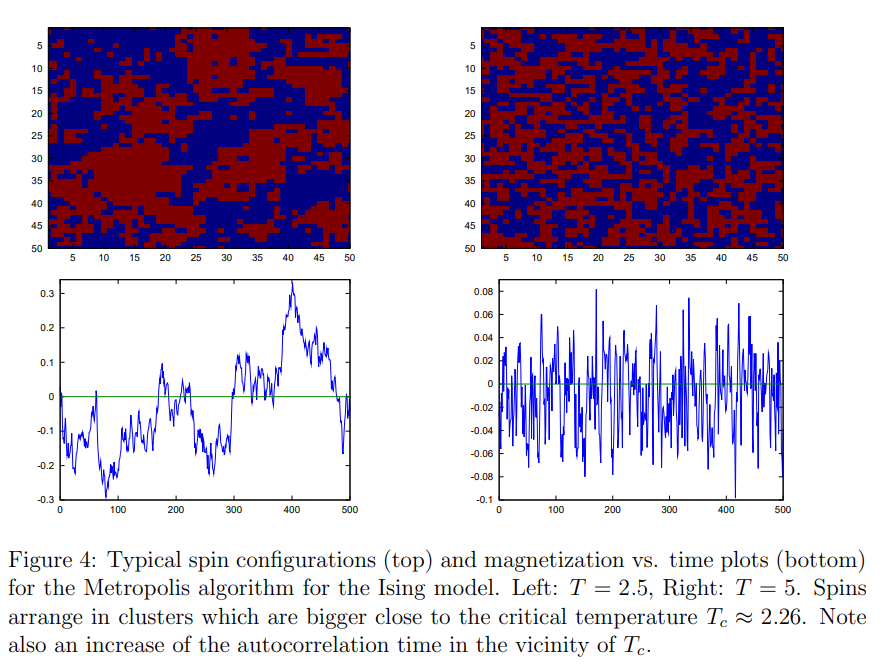

In [20]:
display(Image(filename='equilibration_Isingmodel_v2.png', width = 600))
#reference http://itf.fys.kuleuven.be/~enrico/Teaching/monte_carlo_2012.pdf

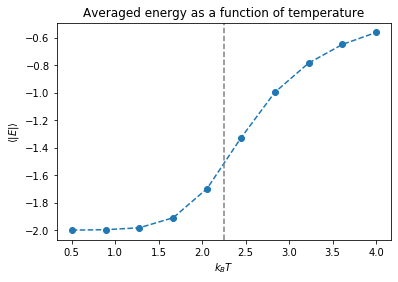

In [21]:
#plotting energy
plt.plot(list_kBT, list_en, "--o", label="k_BT")
plt.xlabel(r'$k_BT$')
plt.ylabel(r'$ \langle |E| \rangle $')
plt.axvline(x=1/beta_c, color='gray', linestyle='dashed') #theoretically expected T_c
plt.title('Averaged energy as a function of temperature')
plt.show()

Notice that for temperatures above $T_c$, if spins are randomly oriented, we would expect $\langle E \rangle \to 0$ as $T \to \infty$. As $\langle E \rangle \neq 0$, it means the neighboring spins are correlated.

In [22]:
# L = 50 #system size
# N = L*L
# N_iter = 10000 #number of iteration 
# list_kBT = np.linspace(0.5, 4, 10) #temperature range
# list_en = []
# list_m_abs = []
# #added
# list_cv=[]
# list_chi=[]

# for kBT in list_kBT: #for each temperature
#     #changed
#     S, en, m_abs, m, m_sq, en_sq = local_MC(L, N_iter, 1/kBT)
#     list_en.append(en/N)
#     list_m_abs.append(m_abs/N)
#     list_cv.append(specific_heat(N, en, en_sq, kBT))
#     list_chi.append(susceptibility(N, m, m_sq, kBT))
    
# #plotting specific heat and susceptibility
# plt.plot(list_kBT, list_cv, "--o", label="k_BT")
# plt.xlabel(r'$k_BT$')
# plt.ylabel(r'$c_V$')
# plt.axvline(x=1/beta_c, color='gray', linestyle='dashed') #theoretically expected T_c
# plt.title('Specific heat as a function of temperature')
# plt.show()

# plt.plot(list_kBT, list_chi, "--o", label="k_BT")
# plt.xlabel(r'$k_BT$')
# plt.ylabel(r'$\chi$')
# plt.axvline(x=1/beta_c, color='gray', linestyle='dashed') #theoretically expected T_c
# plt.title('Susceptibility as a function of temperature')
# plt.show()

On the bigger lattice we can better see expected 2nd order phase transition. 

**4) Calculate specific heat and susceptibility of given configurations**

Specific heat is defined as:
$$
c_V=\frac{1}{N} \frac{\partial \langle E\rangle}{\partial T} =\frac{\beta^2}{N} \left( \langle E^2\rangle -\langle E \rangle^2\right)
$$
And susceptibility:
$$
\chi=\frac{\beta^2}{N}(\langle M^2\rangle-\langle M\rangle^2),
$$

In [23]:
def local_MC(L, N_iter, beta): #a function of lattice size, number of iteration and inverse temperature
    N = L * L
    S = [random.choice([-1, 1]) for k in range(N)] #random orientation of each spin
    nbr, site_dic, x_y_dic = square_neighbors(L) #neighbors defined above
    
    en = 0
    m_abs = 0
    #added
    m = 0
    m_sq = 0
    en_sq = 0
    
    for i_sweep in range(N_iter): #for each iteration
        for iter in range(N): #going over sites
            k = random.randint(0, N-1) #chosing one among spins randomly
            h = sum(S[nbr[k][j]] for j in range(4)) #calculating the field of neighboring spins acting on it
            Delta_E = 2 * h * S[k] #energy difference
            BoltzmanF = np.exp(- beta * Delta_E) #calculating Boltzman factor
            if BoltzmanF > random.random(): S[k] = -S[k] #Metropolis criterion for flipping spin at position k
                
        M = magnetization(S,N)
        E = energy(S,N,nbr)
        en += E/N_iter #averaged
        m_abs += abs(M)/N_iter
        #added
        m += M/N_iter
        m_sq += M**2/N_iter
        en_sq += E**2/N_iter
    return S, en, m_abs, m, m_sq, en_sq

Let's calculate the dependence of thermodynamic quantities in a small system using the our local Metropolis MC algorithm:

In [24]:
#definition of energy and magnetization for a given configuration S

def specific_heat(N, en, en_sq, kBT):
    cv = (en_sq-en**2)/(N*kBT**2)
    return cv

def susceptibility(N, m, m_sq, kBT):
    susc = (m_sq-m**2)/(N*kBT**2)
    return susc

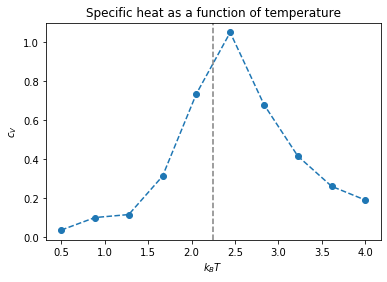

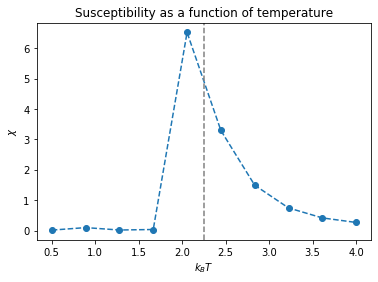

In [25]:
L = 6 #system size
N = L*L
N_iter = 10000 #number of iteration 
list_kBT = np.linspace(0.5, 4, 10) #temperature range
list_en = []
list_m_abs = []
#added
list_cv=[]
list_chi=[]

for kBT in list_kBT: #for each temperature
    #changed
    S, en, m_abs, m, m_sq, en_sq = local_MC(L, N_iter, 1/kBT)
    list_en.append(en/N)
    list_m_abs.append(m_abs/N)
    list_cv.append(specific_heat(N, en, en_sq, kBT))
    list_chi.append(susceptibility(N, m, m_sq, kBT))
    
#plotting specific heat and susceptibility
plt.plot(list_kBT, list_cv, "--o", label="k_BT")
plt.xlabel(r'$k_BT$')
plt.ylabel(r'$c_V$')
plt.axvline(x=1/beta_c, color='gray', linestyle='dashed') #theoretically expected T_c
plt.title('Specific heat as a function of temperature')
plt.show()

plt.plot(list_kBT, list_chi, "--o", label="k_BT")
plt.xlabel(r'$k_BT$')
plt.ylabel(r'$\chi$')
plt.axvline(x=1/beta_c, color='gray', linestyle='dashed') #theoretically expected T_c
plt.title('Susceptibility as a function of temperature')
plt.show()

## Aim 2: Heat bath and Wolf cluster MC algorithms

**The motivation to speed up MC algorithm**

The detailed balance condition in Metropolis-Hastings MC algorithm requires:
$$ \pi(a) p_{a \to b} = \pi(b) p_{b \to a}$$
There will be lots of rejections for proposed moves at low temperatures.

**Metropolis-Hastings algorithm** (still a single-flip algorithm that satisfies detailed balance condition): We can define the a priori probability, ${\cal A}_{a \to b}$ giving the probability of producing configuration $b$ from configuration $a$. ${\cal A}_{a \to b}$ is zero if the configuration $b$ cannot be proposed starting from $a$ and gives the probability to propose the configuration $b$ otherwise. Note that
$$p_{b \to a} \to p_{a \to b} {\cal A}_{a \to b}$$
and the probability of accpeting the move is then given by the Metropolis-Hastings prescription:
$$ p_{a \to b}=\min \left(1,\frac{\pi(b) {\cal A}_{b \to a}}{\pi(a)\, {\cal A}_{a \to b} } \right)$$

In standard Metropolis algorithm above we took ${\cal A}_{b \to a}= {\cal A}_{a \to b}$.

### Algorithm 2: Heat bath

The heat bath algorithm is the Metropolis-Hastings algorithm with apriori probability given as (for Ising model):

$$\mathcal{A}(a\to b)=\frac{e^{-\beta E_b}}{e^{-\beta E_a}+e^{-\beta E_b}} = \frac{e^{-\beta \Delta }}{1 + e^{-\beta \Delta}} = \pi(b)$$

In particular:

$$\pi_{a \to \uparrow}= \frac{1}{1+e^{- 2\beta h}} \quad \pi_{a \to \downarrow}= \frac{1}{1+e^{ 2\beta h}}$$

In general, heat bath algorithm is faster than Metropolis algorithm (although not for Ising model).

**5) Implement heat bath algorithm to calculate the same observables**

In [26]:
def heat_bath(L, N_iter, beta): #a function of lattice size, number of iteration and inverse temperature
    N = L * L
    S = [random.choice([-1, 1]) for k in range(N)] #random orientation of each spin
    nbr, site_dic, x_y_dic = square_neighbors(L) #neighbors defined above
    
    en = 0
    m_abs = 0
    m = 0
    m_sq = 0
    en_sq = 0
    
    for i_sweep in range(N_iter): #for each iteration
        for iter in range(N): #going over sites
            k = random.randint(0, N-1) #chosing one among spins randomly
            h = sum(S[nbr[k][j]] for j in range(4)) #calculating the field of neighboring spins acting on it
            
            pi_plus = 1/(np.exp(-2*beta*h) + 1)
            S[k] = -1 #spin is down
            if pi_plus > random.random(): S[k] = +1 #unless the probability pi_plus requires it to be up
                
        M = magnetization(S,N)
        E = energy(S,N,nbr)
        en += E/N_iter #averaged
        m_abs += abs(M)/N_iter
        m += M/N_iter
        m_sq += M**2/N_iter
        en_sq += E**2/N_iter
    return S, en, m_abs, m, m_sq, en_sq

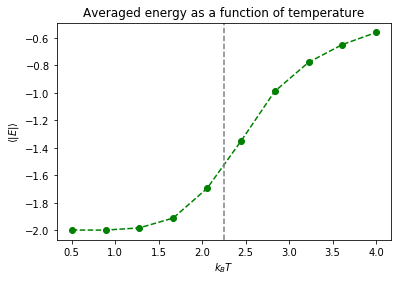

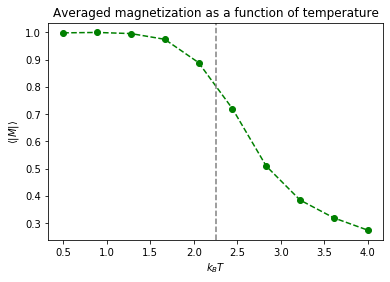

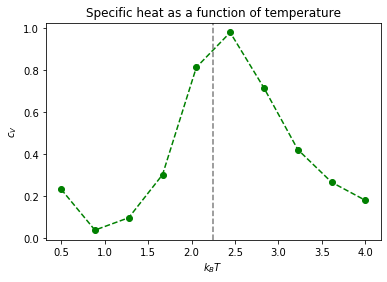

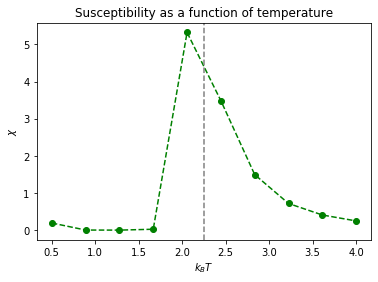

In [27]:
L = 6 #system size
N = L*L
N_iter = 10000 #number of iteration 
list_kBT = np.linspace(0.5, 4, 10) #temperature range
list_en = []
list_m_abs = []
#added
list_cv=[]
list_chi=[]

for kBT in list_kBT: #for each temperature
    #changed
    S, en, m_abs, m, m_sq, en_sq = local_MC(L, N_iter, 1/kBT)
    list_en.append(en/N)
    list_m_abs.append(m_abs/N)
    list_cv.append(specific_heat(N, en, en_sq, kBT))
    list_chi.append(susceptibility(N, m, m_sq, kBT))

#plotting energy
plt.plot(list_kBT, list_en, "g--o", label="k_BT")
plt.xlabel(r'$k_BT$')
plt.ylabel(r'$ \langle |E| \rangle $')
plt.axvline(x=1/beta_c, color='gray', linestyle='dashed') #theoretically expected T_c
plt.title('Averaged energy as a function of temperature')
plt.show()

#plotting magnetization
plt.plot(list_kBT, list_m_abs, "g--o", label="k_BT")
plt.xlabel(r'$k_BT$')
plt.ylabel(r'$ \langle |M| \rangle $')
plt.axvline(x=1/beta_c, color='gray', linestyle='dashed') #theoretically expected T_c
plt.title('Averaged magnetization as a function of temperature')
plt.show()
    
#plotting specific heat
plt.plot(list_kBT, list_cv, "g--o", label="k_BT")
plt.xlabel(r'$k_BT$')
plt.ylabel(r'$c_V$')
plt.axvline(x=1/beta_c, color='gray', linestyle='dashed') #theoretically expected T_c
plt.title('Specific heat as a function of temperature')
plt.show()

#plotting susceptibility
plt.plot(list_kBT, list_chi, "g--o", label="k_BT")
plt.xlabel(r'$k_BT$')
plt.ylabel(r'$\chi$')
plt.axvline(x=1/beta_c, color='gray', linestyle='dashed') #theoretically expected T_c
plt.title('Susceptibility as a function of temperature')
plt.show()

In [28]:
# #plotting susceptibility
# plt.plot(list_kBT, list_chi, "g--o", label="k_BT")
# plt.xlabel(r'$k_BT$')
# plt.ylabel(r'$\chi$')
# plt.axvline(x=1/beta_c, color='gray', linestyle='dashed') #theoretically expected T_c
# plt.title('Susceptibility as a function of temperature')
# plt.show()

In [29]:
# #on a bigger lattice
# L = 50 #system size
# N = L*L
# N_iter = 10000 #number of iteration 
# list_kBT = np.linspace(0.5, 4, 100) #temperature range
# list_en = []
# list_m_abs = []
# list_cv=[]
# list_chi=[]
# for i in list_kBT: #for each temperature
#     S, en, m_abs, m, m_sq, en_sq = heat_bath(L, N_iter, 1/i)
#     list_en.append(en/N)
#     list_m_abs.append(m_abs/N)
#     list_cv.append(specific_heat(N, en, en_sq, kBT))
#     list_chi.append(susceptibility(N, m, m_sq, kBT))
    
# #plotting magnetization
# plt.plot(list_kBT, list_m_abs, "g--o", label="k_BT")
# plt.xlabel(r'$k_BT$')
# plt.ylabel(r'$ \langle |M| \rangle $')
# plt.axvline(x=1/0.44407, color='gray', linestyle='dashed') #theoretically expected T_c
# plt.title('Averaged magnetization as a function of temperature')
# plt.show()

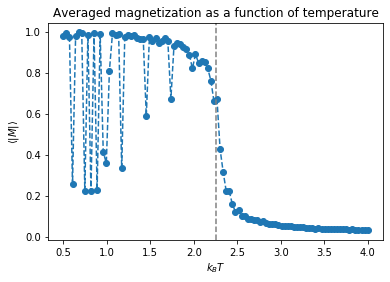

In [30]:
display(Image(filename='compare_Metropolis.png', width = 400))

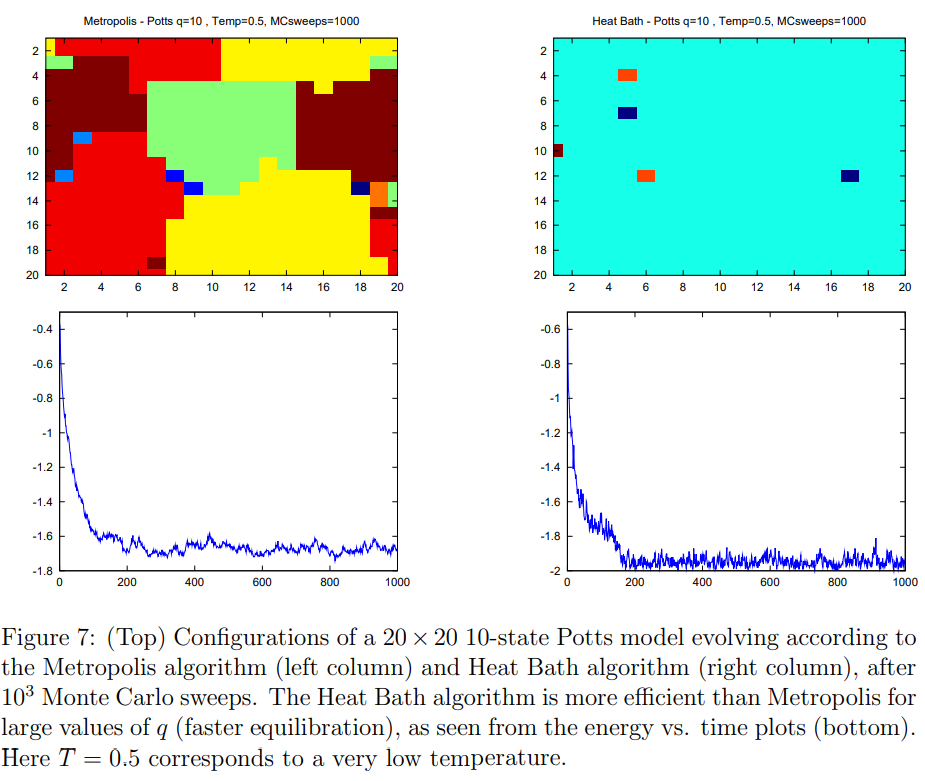

In [31]:
display(Image(filename='MetropolisVsHeatBath_Pottsmodel.png', width = 600))
#reference http://itf.fys.kuleuven.be/~enrico/Teaching/monte_carlo_2012.pdf

### Algorithm 3: Cluster Algorithm

Single-spin-flip Monte Carlo algorithms are slow close to $T_c$, because the histogram of essential values of the magnetization is wide and the step width of the magnetization is small. To sample faster, we must consider moves which change the magnetization by more than $\pm 2$. However, using the single-spin-flip algorithm in parallel, on several sites at a time, only hikes up the rejection rate. Neither can we, so to speak, solidly connect all neighboring spins of the same orientation and flip them all at once. Doing so would quickly lead to a perfectly aligned state, from which there would be no escape.
Swendsen - Wang and Wolff,
have proposed a cluster algorithm, which has been the role models for about a generation of research.

* R. H. Swendsen, J. S. Wang (1987) Nonuniversal critical-dynamics in
Monte-Carlo simulations, Physical Review Letters 58, 86–88
* U. Wolff (1989) Collective Monte-Carlo updating for spin systems, Physical Review Letters 62, 361–364

In the Wolff cluster algorithm we grow **the island** of spins all pointing up/down. Starting from a spin chosen at random, we look at it's neighboring spins. Those with the same sign as the seed spin are adjoint to the island with a probability $p=1-e^{-2 \beta}$, while the neighboring spins of the opposite sign are ignored. We grow the island by iterating the procedure through new spins. 
* In the Wolff implementation, once the island is made, we turn all of the spins on the island (see code below).
* In the Swendsen and Wang version all spins are grouped in islands so that each spin belong to a given island. Then we pick one island at random and flip it. Both version are useful.

It's easy to show that for $p=1-e^{-2 \beta}$, the construction becomes rejection-free.

In [32]:
def Wolff(L, N_iter, beta): #a function of lattice size, number of iteration and inverse temperature
    N = L * L
    S = [random.choice([-1, 1]) for k in range(N)] #random orientation of each spin
    nbr, site_dic, x_y_dic = square_neighbors(L) #neighbors defined above
    p = 1.0 - np.exp(-2.*beta) #probability p for adding the spins of the same sign to the pocket 
    
    m_abs = 0
    m = 0
    m_sq = 0
    
    for i_sweep in range(N_iter): #for each iteration
        k = random.randint(0, N-1) #choosing one spin randomly
        Pocket = [k] #putting spin k into pocket
        Cluster = [k] #putting pocket into cluster
        N_cluster = 1
        while Pocket != []: #while pocket isn't empty
            k = random.choice(Pocket) #for a random spin in a pocket
            for l in nbr[k]: #we go through all the neighbors
                if S[l] == S[k] and l not in Cluster and random.uniform(0,1) < p: #if they are of the same sign
                    Pocket.append(l) #we see them as the same-sign neighbors that will be added
                    Cluster.append(l) #we add them with probability p
                    N_cluster += 1 #the size of our island grows by 1
            Pocket.remove(k) #we will continue growing the island looking now at some other spin chosen randomly in the pocket
            
        #once the island is grown
        for k in Cluster: 
            S[k] = - S[k] #we switch all the spins within the island

        M = magnetization(S,N)
        m_abs += abs(M)/N_iter
        m += M/N_iter
        m_sq += M**2/N_iter
    return S, m_abs, m, m_sq

In [33]:
#function for plotting cofiguration
def plotconf(S, L):
    plot_output = np.reshape(S, (L,L)).T
    plt.imshow(plot_output, cmap='bwr') #red - spin up, blue - spin down

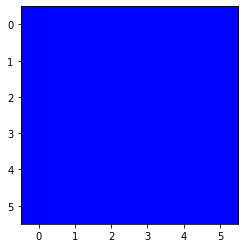

In [34]:
#below T_c - polarized case
beta = 0.5 #below T_c
N_iter = 20000 #number of iterations
S, m_abs, m, m_sq = Wolff(L, N_iter, beta) 
plotconf(S, L)

**6) Calculate the susceptibility $\chi$ for the system size L = 10, 15, 25, 30 and plot the results.**

In [35]:
def suscL(L): 
    N = L*L
    N_iter = 20000 #number of iteration 
    list_kBT = np.linspace(0.5, 4, 10) #temperature range
    list_m_abs = []
    list_chi = []

    for kBT in list_kBT: #for each temperature
        S, m_abs, m, m_sq = Wolff(L, N_iter, 1/kBT)
        list_chi.append(susceptibility(N, m, m_sq, kBT))
    return list_chi

In [36]:
# susc10 = suscL(10)
# susc15 = suscL(15)
# susc25 = suscL(25)
# susc30 = suscL(30)

In [37]:
# #plotting susceptibility
# fig, ax = plt.subplots()
# plt.plot(list_kBT, susc10, "g--o", label=r'$L=10$')
# plt.plot(list_kBT, susc15, "b--o", label=r'$L=15$')
# plt.plot(list_kBT, susc25, "m--o", label=r'$L=25$')
# plt.plot(list_kBT, susc30, "r--o", label=r'$L=30$')
# leg = ax.legend();
# plt.xlabel(r'$k_BT$')
# plt.ylabel(r'$\chi$')
# plt.axvline(x=1/beta_c, color='gray', linestyle='dashed') #theoretically expected T_c
# plt.title('Susceptibility as a function of temperature')
# plt.show()

**7) Compare the  exact critical exponent for Ising model $\gamma = 7/4=1.75$ where $\chi\propto \frac{1}{|T-T_c|^{\gamma}}$ with the MC calculation for $L=25$. Calculate the susceptibility at 10 equidistant points between $[T_c+0.05,4]$ and plot the results as a function of $T-T_c$ in the log-log plot and compare it with the function $ |T-T_c|^{-1.75}$ in the same plot.**

In [38]:
L = 25
N = L*L
N_iter = 20000
list_chi = []
exact = []
DeltaT = []
list_kBT = np.linspace((1/beta_c)+0.05, 4, 10)

for kBT in list_kBT: #for each temperature
    S, m_abs, m, m_sq = Wolff(L, N_iter, 1/kBT)
    list_chi.append(1/N/i**2*(m_sq-m**2))
    DeltaT.append(kBT-(1/beta_c))
    exact.append((kBT-(1/beta_c))**(-1.75))

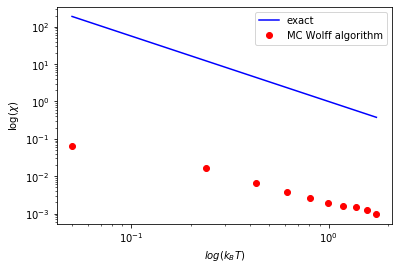

In [39]:
fig, ax = plt.subplots()
plt.loglog(DeltaT, exact, '-b', label='exact')
plt.loglog(DeltaT, list_chi, 'ro', label='MC Wolff algorithm')
leg = ax.legend();
plt.xlabel(r'$log(k_BT)$')
plt.ylabel(r'$\log(\chi)$')
plt.show()